In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pydicom, numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import json
from PIL import Image
from IPython.display import display
import os
import plotly.graph_objects as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from plotly.offline import init_notebook_mode
from plotly.offline import iplot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.applications import DenseNet121
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading Datasets

In [2]:
train_df = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
test_df = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')
subs_df = pd.read_csv('../input/siim-isic-melanoma-classification/sample_submission.csv')

image_path = '../input/siim-isic-melanoma-classification/train/'

print('The size of training data : {}'.format(train_df.shape))
print('The size of testing data : {}'.format(test_df.shape))

The size of training data : (33126, 8)
The size of testing data : (10982, 5)


In [3]:
train_df.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

In [4]:
a = np.mean(train_df.target)
print('The Distribution of Training dataset : {}'.format(a))

The Distribution of Training dataset : 0.01762965646320111


***Based on above value it is an binary classification type dataset***

# Visualizing Missing values

In [5]:
plt.figure(figsize = (17,7))
percent_missing = train_df.isnull().sum() / (train_df.shape[0])*100
percent_missing.iplot(kind = 'bar',color ='blue')

<Figure size 1224x504 with 0 Axes>

In [6]:
train_df.describe()

age_approx        target
count  33058.000000  33126.000000
mean      48.870016      0.017630
std       14.380360      0.131603
min        0.000000      0.000000
25%       40.000000      0.000000
50%       50.000000      0.000000
75%       60.000000      0.000000
max       90.000000      1.000000

**Checking if Patient-ID were duplicated**

In [7]:
print("The total patient ids are {}, from those the unique ids are {}".format(train_df['patient_id'].count(),train_df['patient_id'].value_counts().shape[0] ))

The total patient ids are 33126, from those the unique ids are 2056


In [8]:
benign_gender = train_df.groupby(['benign_malignant']).count()['sex'].to_frame()
benign_gender.head()

sex
benign_malignant       
benign            32477
malignant           584

# Target and Age
**Here I have used box-plot tool of seaborn library to visualize the distribution of age data in the target columns**

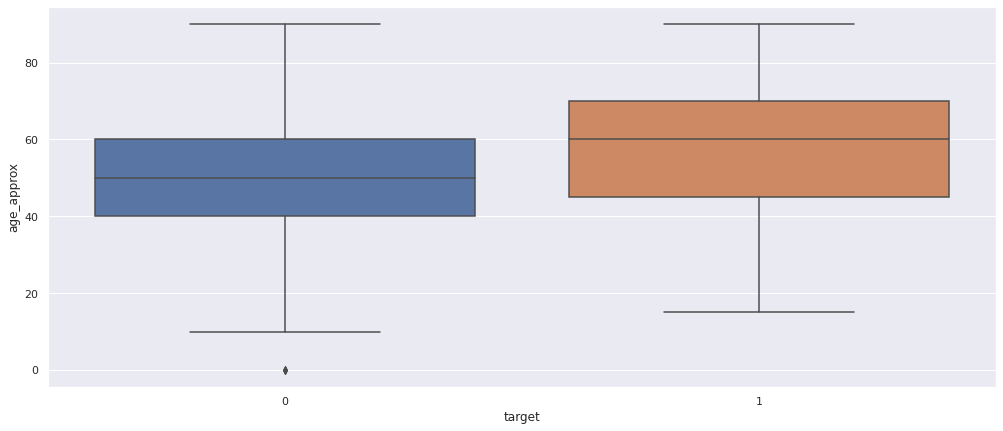

In [9]:
#target and age
plt.figure(figsize = (17,7))
sns.boxplot(x = train_df['target'], y = train_df['age_approx'])

In [10]:
feature_list = ['sex','age_approx','anatom_site_general_challenge'] 
for i in feature_list: 
    train_df[i].value_counts(normalize=True).to_frame().iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='blue',
                                                      theme='pearl',
                                                      bargap=0.8,
                                                      gridcolor='white',                                                     
                                                      title=f'<b>Distribution of {i} in train set.</b>')

    test_df[i].value_counts(normalize=True).to_frame().iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='green',
                                                      theme='pearl',
                                                      bargap=0.8,
                                                      gridcolor='white',                                                     
                                                      title=f'<b>Distribution of {i} in test set.</b>')

# Displaying Images

In [11]:
im = train_df['image_name'].values
display(im)

array(['ISIC_2637011', 'ISIC_0015719', 'ISIC_0052212', ...,
       'ISIC_9999515', 'ISIC_9999666', 'ISIC_9999806'], dtype=object)

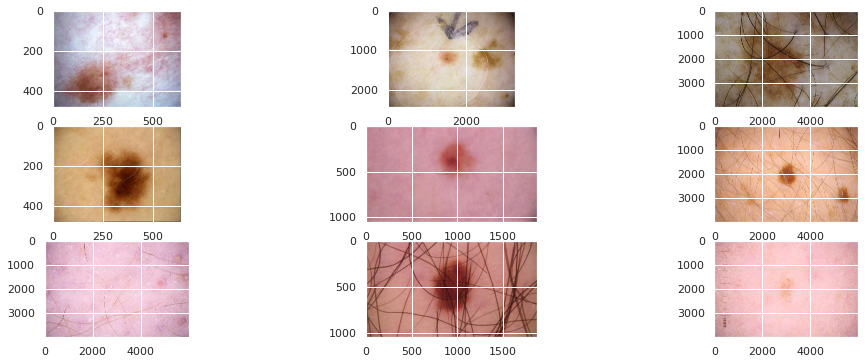

In [12]:
plt.figure(figsize=(17,6))

image_dir = '../input/siim-isic-melanoma-classification/'

img = [np.random.choice(im + '.jpg') for i in range(10)]
img_dir = image_dir + '/jpeg/train'

for i in range(9):
    plt.subplot(3,3, i+1)
    images = plt.imread(os.path.join(img_dir, img[i]))
    plt.imshow(images)

# Display Benign and Malignant images

In [13]:
malignant = train_df[train_df['benign_malignant']=='malignant']
benign = train_df[train_df['benign_malignant']=='benign']

print(malignant)
print(benign)

         image_name  patient_id     sex  age_approx  \
91     ISIC_0149568  IP_0962375  female        55.0   
235    ISIC_0188432  IP_0135517  female        50.0   
314    ISIC_0207268  IP_7735373    male        55.0   
399    ISIC_0232101  IP_8349964    male        65.0   
459    ISIC_0247330  IP_3232631  female        65.0   
...             ...         ...     ...         ...   
32969  ISIC_9955163  IP_7507212    male        55.0   
33000  ISIC_9963177  IP_1165806    male        70.0   
33014  ISIC_9967383  IP_7887363    male        60.0   
33050  ISIC_9978107  IP_2860540    male        65.0   
33117  ISIC_9998682  IP_2516168    male        60.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  
91                  upper extremity  melanoma        malignant       1  
235                 upper extremity  melanoma        malignant       1  
314                           torso  melanoma        malignant       1  
399                           torso  melanoma  

In [14]:
malignant.head(5)

image_name  patient_id     sex  age_approx  \
91   ISIC_0149568  IP_0962375  female        55.0   
235  ISIC_0188432  IP_0135517  female        50.0   
314  ISIC_0207268  IP_7735373    male        55.0   
399  ISIC_0232101  IP_8349964    male        65.0   
459  ISIC_0247330  IP_3232631  female        65.0   

    anatom_site_general_challenge diagnosis benign_malignant  target  
91                upper extremity  melanoma        malignant       1  
235               upper extremity  melanoma        malignant       1  
314                         torso  melanoma        malignant       1  
399                         torso  melanoma        malignant       1  
459               lower extremity  melanoma        malignant       1

In [15]:
benign.head(5)

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

**Malignant**

Random Malignant Images are Displayed!!


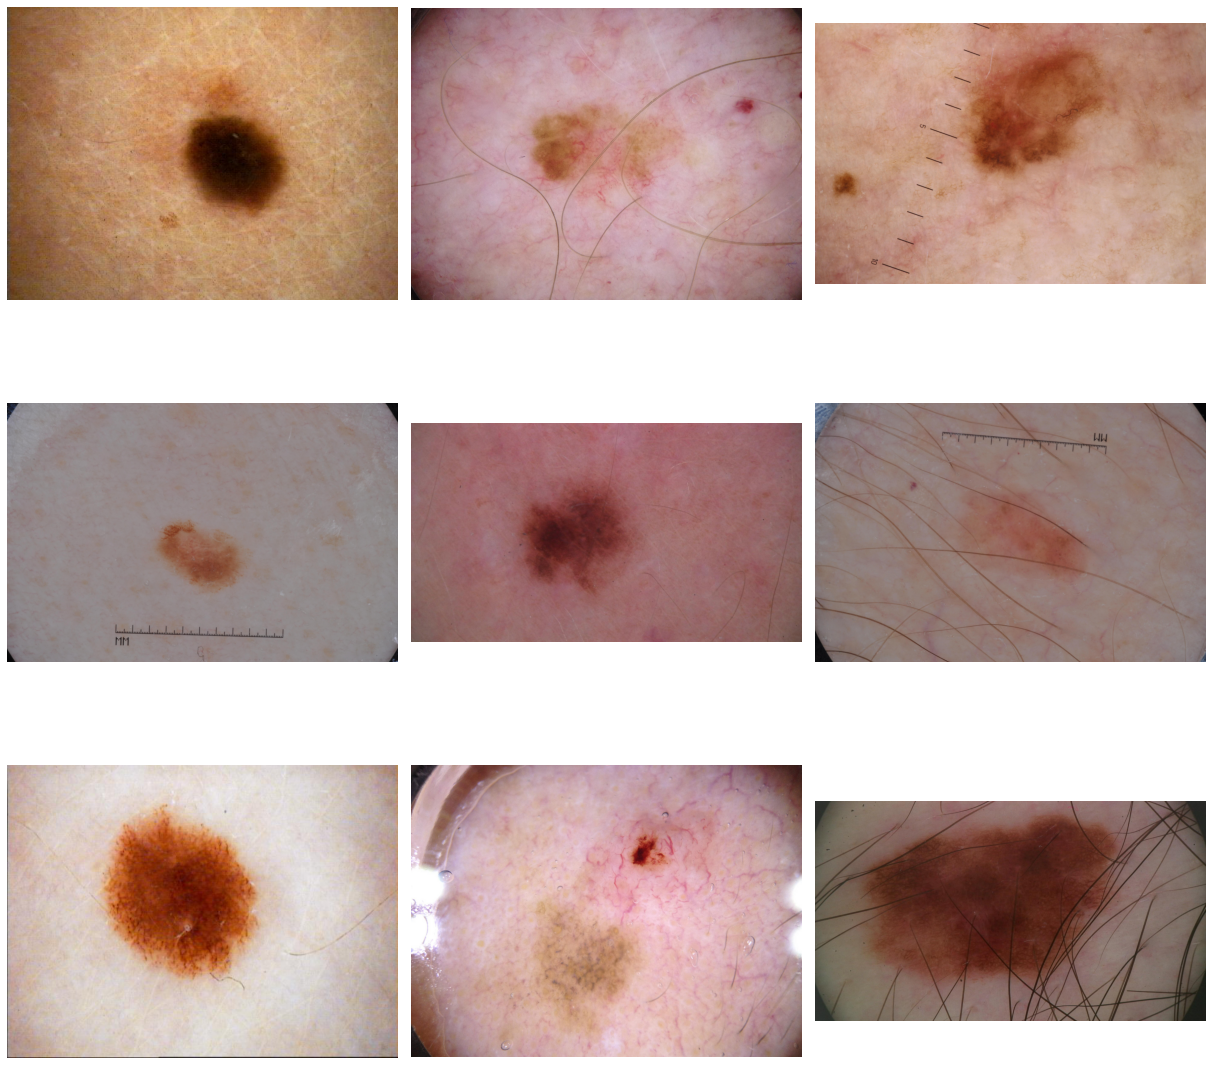

In [16]:
im_malignant = malignant['image_name'].values
image_dir = '../input/siim-isic-melanoma-classification/'

img = [np.random.choice(im_malignant + '.jpg') for i in range(10)]
img_dir = image_dir + '/jpeg/train'
plt.figure(figsize=(17,17))

for i in range(9):
    plt.subplot(3,3, i+1)
    images = plt.imread(os.path.join(img_dir, img[i]))
    plt.imshow(images)
    plt.axis('off')
plt.tight_layout()
print("Random Malignant Images are Displayed!!")

**Benign**

Random Benign Images are displayed!!


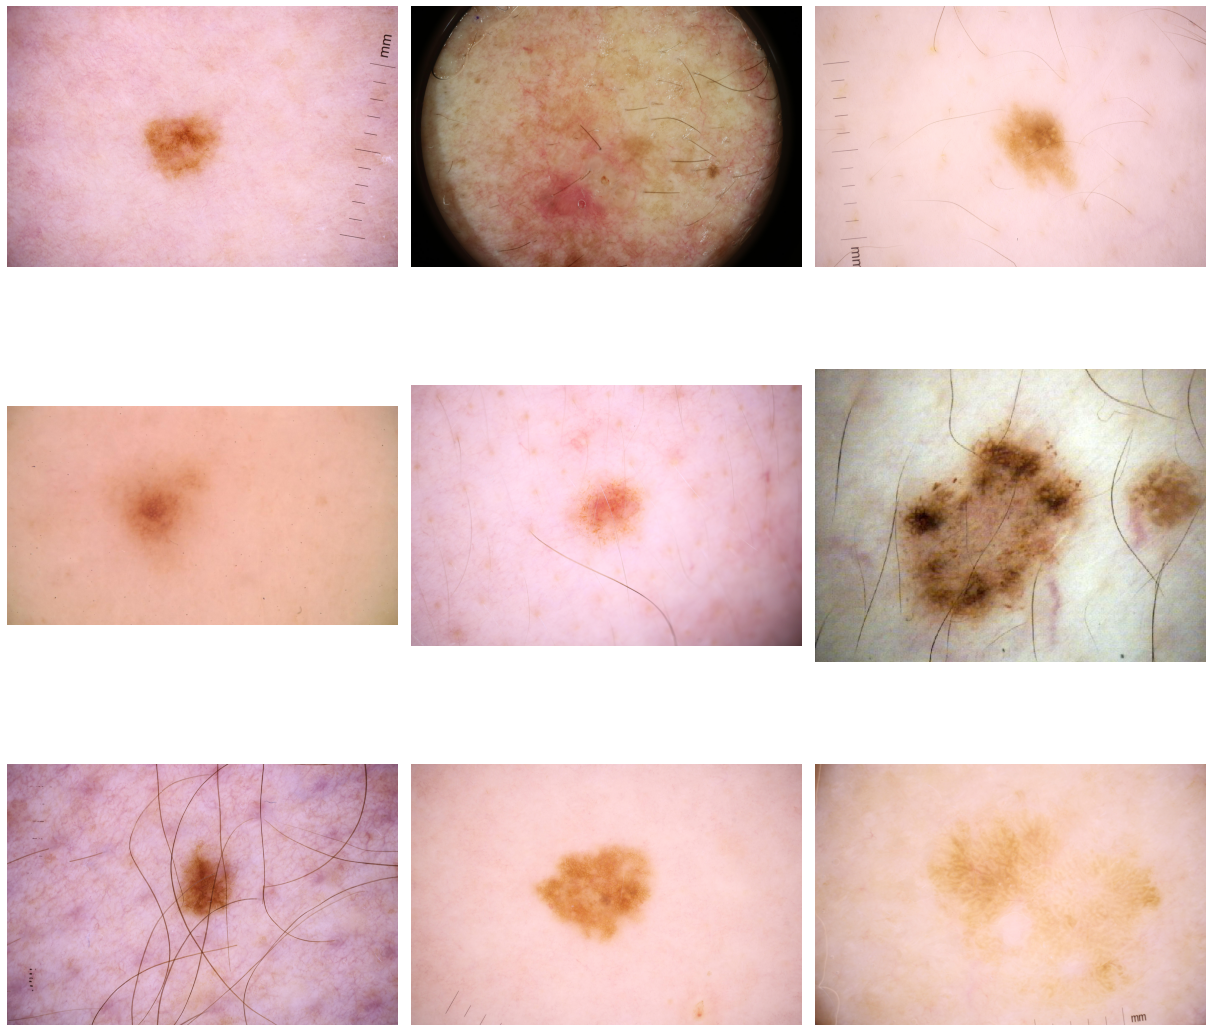

In [17]:
im_benign = benign['image_name'].values
image_dir = '../input/siim-isic-melanoma-classification/'

img = [np.random.choice(im_benign + '.jpg') for i in range(10)]
img_dir = image_dir + '/jpeg/train'
plt.figure(figsize=(17,17))

for i in range(9):
    plt.subplot(3,3, i+1)
    images = plt.imread(os.path.join(img_dir, img[i]))
    plt.imshow(images)
    plt.axis('off')
plt.tight_layout()
print('Random Benign Images are displayed!!')

# DICOM Images

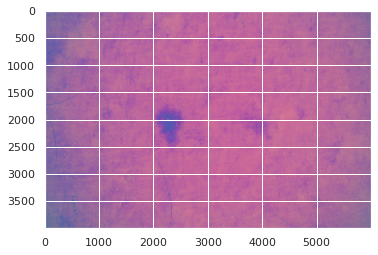

In [18]:
plt.imshow(pydicom.dcmread(image_path + list(train_df['image_name'])[1] + '.dcm').pixel_array)
plt.savefig('x.jpg')

**Benign Images**

--- Benign DICOM Images ---


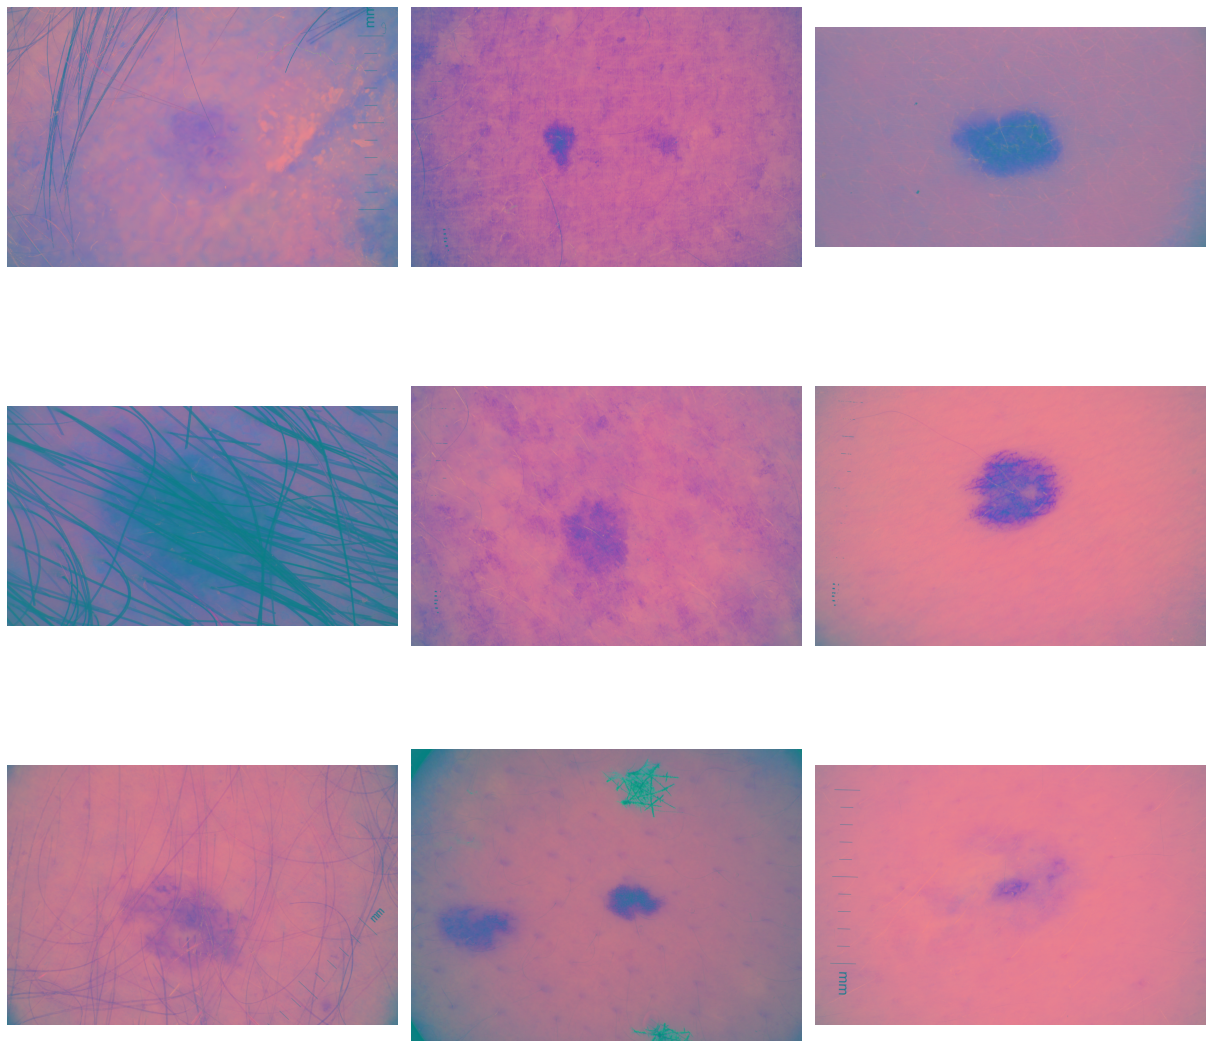

In [19]:
plt.figure(figsize=(17,17))

for i in range(9):
    plt.subplot(3,3, i+1)
    images = pydicom.dcmread(image_path + train_df[train_df['benign_malignant']=='benign']['image_name'][i] + '.dcm')
    plt.imshow(images.pixel_array)
    plt.axis('off')
print("--- Benign DICOM Images ---")
plt.tight_layout()

# Data Imbalance

In [20]:
plt.figure(figsize = (10,10))
data = train_df.benign_malignant.value_counts()
data.iplot(kind = 'bar', color='blue', title = 'Data Imbalance')

<Figure size 720x720 with 0 Axes>

# Diagnosis and Age

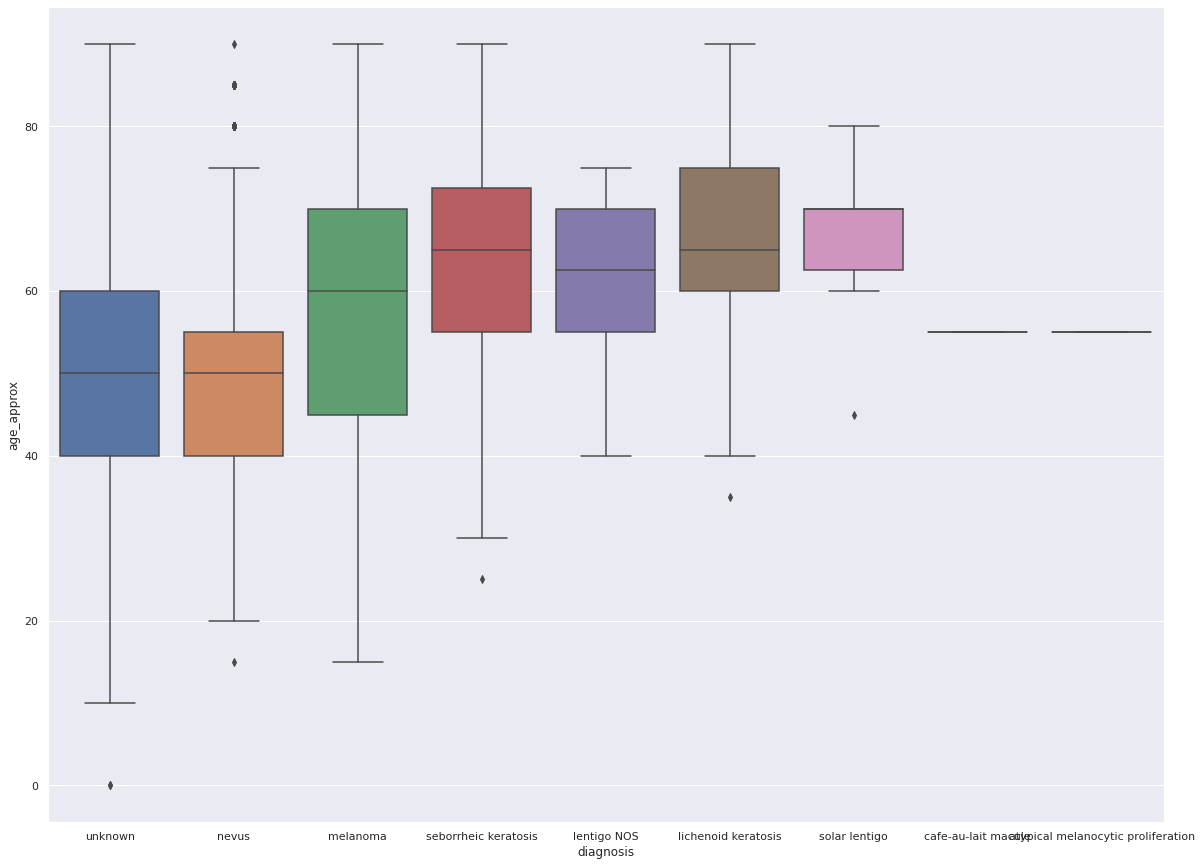

In [21]:
plt.figure(figsize = (20,15))
sns.boxplot(x = train_df['diagnosis'], y = train_df['age_approx'])

# Histograms
Let's visualize the image intensities using histogram 

**Benign Images**

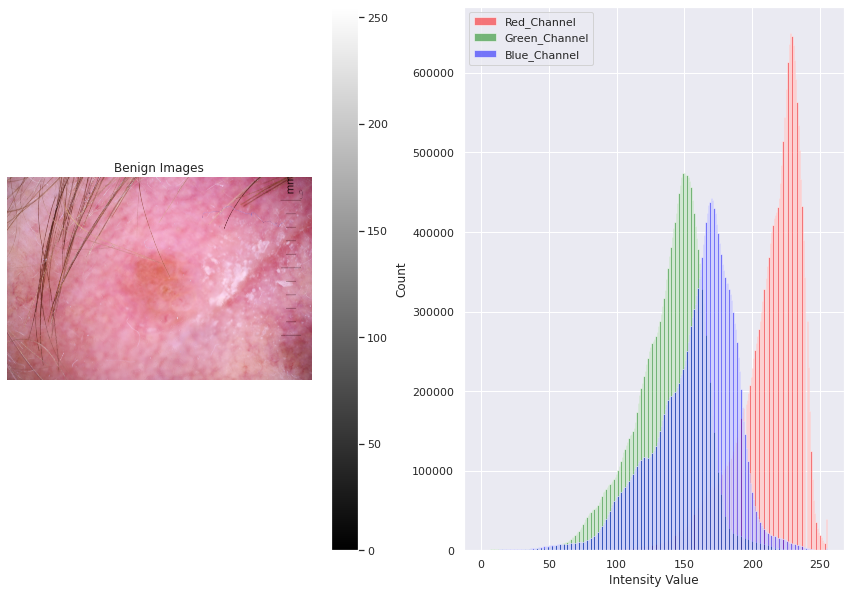

In [22]:
img = im_benign[0] + '.jpg'
f = plt.figure(figsize=(15,10))
f.add_subplot(1,2,1)

images = plt.imread(os.path.join(img_dir, img))
plt.imshow(images, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Benign Images')

f.add_subplot(1,2,2)
_= plt.hist(images[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(images[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(images[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

**Malignant Images**

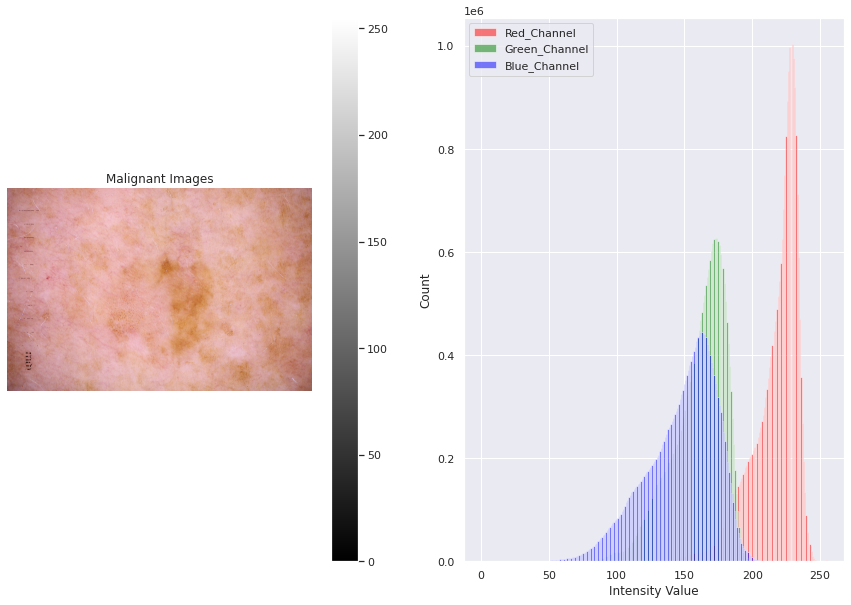

In [23]:
img = im_malignant[0] + '.jpg'
f = plt.figure(figsize=(15,10))
f.add_subplot(1,2,1)

images = plt.imread(os.path.join(img_dir, img))
plt.imshow(images, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Malignant Images')

f.add_subplot(1,2,2)
_= plt.hist(images[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(images[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(images[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

# Create Folds
we first create folds for Stratified Kfold model selection so that the ratio of positive to negative cases remain constant.
You can get more information from [here](http://https://www.youtube.com/watch?v=WaCFd-vL4HA)

In [24]:
from sklearn import model_selection

In [25]:
#using the train.csv data
train_df['kfold'] = -1
train_df = train_df.sample(frac=1).reset_index(drop=True)
y = train_df.target.values
kf = model_selection.StratifiedKFold(n_splits=10)

for f, (t_, v_) in enumerate(kf.split(X=train_df, y=y)):
    train_df.loc[v_, 'kfold'] = f

train_df.to_csv("train_folds.csv", index=False)

In [26]:
def train(fold):
    train_path = "../input/siic-isic-224x224-images/train/"
    df = pd.read_csv('/kaggle/working/train_folds.csv')
    train_batch = 32
    valid_batch = 16
    epochs = 30
    
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    model = DenseNet121(pretrained="imagenet", include_top=False)

    train_aug = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
    
    valid_aug = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
    

    train_images = df_train.image_name.values.tolist()
    train_images = [os.path.join(train_path, i + ".png") for i in train_images]
    train_targets = df_train.target.values

    valid_images = df_valid.image_name.values.tolist()
    valid_images = [os.path.join(training_path, i + ".png") for i in valid_images]
    valid_targets = df_valid.target.values

    train_dataset = train_aug.flow_from_directory(
        image_paths=train_images,
        targets=train_targets,
        resize=None
    )
    
    

    valid_dataset = valid_aug.flow_from_directory(
        image_paths=valid_images,
        targets=valid_targets,
        resize=None
     )

    optimizer = tensorflow.keras.optimizers.Adam(model.parameters(), lr=1e-4)
    scheduler = tensorflow.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_loss',
        patience=3,
        min_lr = 0.001,
        mode="max"
    )
    es = EarlyStopping(patience=5, mode="max")

    for epoch in range(epochs):
        train_loss = Engine.train(train_dataset, model, optimizer)
        predictions, valid_loss = Engine.evaluate(
             valid_dataset, model
        )
        predictions = np.vstack((predictions)).ravel()
        auc = metrics.roc_auc_score(valid_targets, predictions)
        print(f"Epoch = {epoch}, AUC = {auc}")
        scheduler.step(auc)

        es(auc, model, model_path=f"model_fold_{fold}.bin")
        if es.early_stop:
            print("Early stopping")
            break


# Submissions

In [27]:
subs_df.to_csv('submissions.csv', index = False)
print('Successfull!!')

Successfull!!
